<a href="https://colab.research.google.com/github/schmelto/machine-learning/blob/main/Deeplearning/Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dropout
## Version Selection and Imports

In [1]:
# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.test.is_gpu_available():
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Dense, Activation, Input, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
from scipy.stats import reciprocal
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# jupyters magic command
%matplotlib inline

## Helpers

In [19]:
import typing

def plot_images(images: "DatasetV1Adapter", class_names: typing.List[str]) -> None:
    plt.figure(figsize=(12, 10))
    index = 0
    for image, label in images:
        index += 1
        plt.subplot(3, 3, index)
        plt.imshow(image)
        plt.title("Class: {}".format(class_names[label]))
        plt.axis("off")

def plot_learning_curve(
    title: str, x: int, y: int, y_test: int, ylim: float = 0.6
) -> None:
    plt.figure()
    plt.title(title)
    axes = plt.gca()
    axes.set_ylim([ylim, 1])
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    train_sizes = x
    train_scores = y
    test_scores = y_test

    plt.grid()

    plt.plot(
        train_sizes,
        train_scores,
        "o-",
        color=(177 / 255, 6 / 255, 58 / 255),
        label="Training accuracy",
    )
    plt.plot(
        train_sizes,
        test_scores,
        "o-",
        color=(246 / 255, 168 / 255, 0),
        label="Validation accuracy",
    )

    plt.legend(loc="best")


def plot_history(title: str, history: "History", ylim: float = 0.6) -> None:
    y = history.history["accuracy"]
    y_test = history.history["val_accuracy"]
    plot_learning_curve(title, np.arange(1, 1 + len(y)), y, y_test, ylim)

## Loading and Preprocessing

In [7]:
# resize the images to a uniform size
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    return resized_image, label

In [8]:
# download the dataset with labels and with information about the data
data, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

# print the most important information
dataset_size = info.splits['train'].num_examples
print('dataset size: ', dataset_size)
class_names = info.features['label'].names
print('class names: ', class_names)
n_classes = info.features['label'].num_classes
print('number of classes: ', n_classes)

batch_size = 32

try:
  train_data = tfds.load('tf_flowers', split="train[:80%]", as_supervised=True)
  test_data = tfds.load('tf_flowers', split="train[80%:100%]", as_supervised=True)
  train_data = train_data.shuffle(1000).map(preprocess).batch(batch_size).prefetch(1)
  test_data = test_data.map(preprocess).batch(batch_size).prefetch(1)
except(Exception):
  # split the data into train and test data with a 8:2 ratio
  train_split, test_split = tfds.Split.TRAIN.subsplit([8, 2])
  train_data = tfds.load('tf_flowers', split=train_split, as_supervised=True)
  test_data = tfds.load('tf_flowers', split=test_split, as_supervised=True)
  train_data = train_data.shuffle(1000).map(preprocess).batch(batch_size).prefetch(1)
  test_data = test_data.map(preprocess).batch(batch_size).prefetch(1) 

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
dataset size:  3670
class names:  ['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']
number of classes:  5


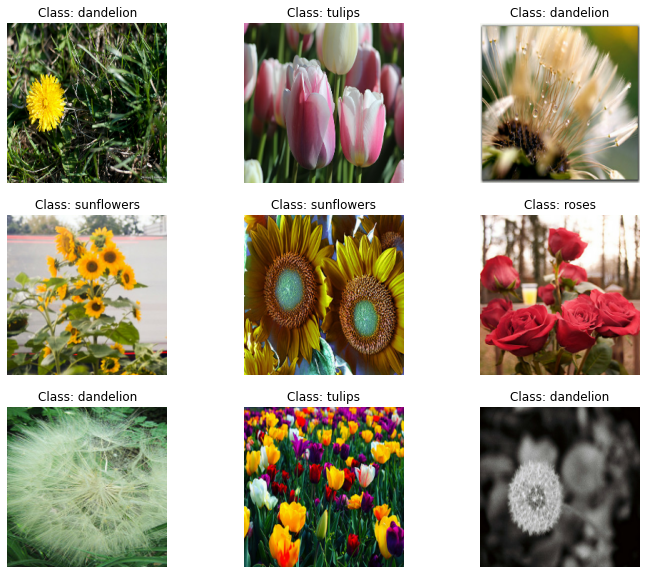

In [9]:
# show some images from the dataset
plot_images(train_data.unbatch().take(9).map(lambda x, y: (x / 255, y)), class_names)

## Model Definition and Training

In [10]:
# model without Dropout
learning_rate=0.0001
momentum=0.9
decay=0.01
dense_neurons=1000
n_filters=32
first_kernel_size=(7,7)

activation='elu'

# input size of images must be 224x224 with RGB color
input_layer = Input(shape=(224, 224, 3))

# Convolutional Neural Network
# It consists of 5 stacked Convolutional Layers with Max Pooling
model = Conv2D(filters=n_filters, kernel_size=(7,7), activation=activation)(input_layer)
model = MaxPooling2D((2,2))(model)

for i in range(2, 5):
  model = Conv2D(
      filters = i * n_filters, 
      kernel_size=(3,3), 
      activation=activation
    )(model)
  model = MaxPooling2D((2,2))(model)

model = Conv2D(filters = 5 * n_filters, 
  kernel_size=(3,3), 
  activation=activation, 
  padding='same'
)(model)
model = MaxPooling2D((2,2))(model)

# Fully-Connected-Classifier
model = Flatten()(model)
model = Dense(dense_neurons, activation=activation)(model)

model = Dense(dense_neurons / 2, activation='tanh')(model)

# Output Layer
output = Dense(n_classes, activation="softmax")(model)

CNN_model = Model(input_layer, output)

# Compiling model
optimizer = keras.optimizers.SGD(lr=learning_rate, momentum=momentum, decay=decay)
CNN_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
            metrics=["accuracy"])


In [11]:
CNN_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 218, 218, 32)      4736      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 109, 109, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 107, 107, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 53, 53, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 51, 51, 96)        55392     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 25, 25, 96)        0     

In [12]:
# Train the model without Dropout
history = CNN_model.fit(
    train_data,
    epochs=100,
    validation_data=test_data
)

Epoch 1/100
92/92 [==============================] - 12s 57ms/step - loss: 1.5849 - accuracy: 0.2994 - val_loss: 1.2945 - val_accuracy: 0.4441
Epoch 2/100
92/92 [==============================] - 4s 41ms/step - loss: 1.2510 - accuracy: 0.4868 - val_loss: 1.1845 - val_accuracy: 0.5150
Epoch 3/100
92/92 [==============================] - 4s 42ms/step - loss: 1.1492 - accuracy: 0.5294 - val_loss: 1.1695 - val_accuracy: 0.5259
Epoch 4/100
92/92 [==============================] - 4s 41ms/step - loss: 1.1207 - accuracy: 0.5395 - val_loss: 1.1071 - val_accuracy: 0.5681
Epoch 5/100
92/92 [==============================] - 4s 41ms/step - loss: 1.0558 - accuracy: 0.5796 - val_loss: 1.0878 - val_accuracy: 0.5804
Epoch 6/100
92/92 [==============================] - 4s 41ms/step - loss: 1.0068 - accuracy: 0.6131 - val_loss: 1.0726 - val_accuracy: 0.5845
Epoch 7/100
92/92 [==============================] - 4s 41ms/step - loss: 0.9856 - accuracy: 0.6274 - val_loss: 1.0586 - val_accuracy: 0.5926
Epoch

In [13]:
from tensorflow.keras.layers import Dropout

# model with Dropout
learning_rate=0.0001
momentum=0.9
decay=0.001
dense_neurons=1000
n_filters=32
first_kernel_size=(7,7)

activation='elu'

# input size of images must be 224x224 with RGB color
input_layer = Input(shape=(224, 224, 3))

# Convolutional Neural Network
# It consists of 5 stacked Convolutional Layers with Max Pooling
model = Conv2D(
    filters=n_filters, 
    kernel_size=(7,7), 
    activation=activation
    )(input_layer)
model = MaxPooling2D((2,2))(model)

for i in range(2, 5):
  model = Conv2D(
      filters = i * n_filters, 
      kernel_size=(3,3), 
      activation=activation
    )(model)
  model = MaxPooling2D((2,2))(model)

model = Conv2D(filters = 5 * n_filters, 
  kernel_size=(3,3), 
  activation=activation, 
  padding='same'
)(model)
model = MaxPooling2D((2,2))(model)

# Fully-Connected-Classifier
model = Flatten()(model)
model = Dense(dense_neurons, activation=activation)(model)
model = Dropout(0.5)(model)

model = Dense(dense_neurons / 2, activation='tanh')(model)
model = Dropout(0.5)(model)

# Output Layer
output = Dense(n_classes, activation="softmax")(model)

CNN_Dropout_model = Model(input_layer, output)

# Compiling model
optimizer = keras.optimizers.SGD(
    lr=learning_rate, 
    momentum=momentum, 
    decay=decay
    )
CNN_Dropout_model.compile(
    loss="sparse_categorical_crossentropy", 
    optimizer=optimizer,
    metrics=["accuracy"]
    )

In [14]:
# Train the model with Dropout
history_dropout = CNN_Dropout_model.fit(
    train_data,
    epochs=100,
    validation_data=test_data
)

Epoch 1/100
92/92 [==============================] - 5s 43ms/step - loss: 2.5747 - accuracy: 0.2032 - val_loss: 1.8144 - val_accuracy: 0.2357
Epoch 2/100
92/92 [==============================] - 4s 41ms/step - loss: 2.4448 - accuracy: 0.1950 - val_loss: 1.6563 - val_accuracy: 0.2371
Epoch 3/100
92/92 [==============================] - 4s 41ms/step - loss: 2.4984 - accuracy: 0.1927 - val_loss: 1.6394 - val_accuracy: 0.2057
Epoch 4/100
92/92 [==============================] - 4s 41ms/step - loss: 2.3977 - accuracy: 0.2203 - val_loss: 1.7885 - val_accuracy: 0.2275
Epoch 5/100
92/92 [==============================] - 4s 41ms/step - loss: 2.3049 - accuracy: 0.2266 - val_loss: 1.6553 - val_accuracy: 0.2098
Epoch 6/100
92/92 [==============================] - 4s 41ms/step - loss: 2.3240 - accuracy: 0.2166 - val_loss: 1.5998 - val_accuracy: 0.2997
Epoch 7/100
92/92 [==============================] - 4s 41ms/step - loss: 2.2879 - accuracy: 0.2224 - val_loss: 1.5276 - val_accuracy: 0.3188
Epoch 

# Visualize Results

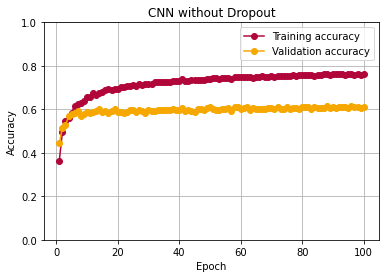

In [20]:
plot_history('CNN without Dropout', history, 0)

# validation accuracy might be sometimes higher than training accuracy due to 2 reasons:
#     - train acc is calculated as the mean of the whole epoch, test acc is calculated after each epoch
#       (where the model is better than in the mid of the epoch)
#     - when you use e.g. Dropout, the behavior at training time is different 

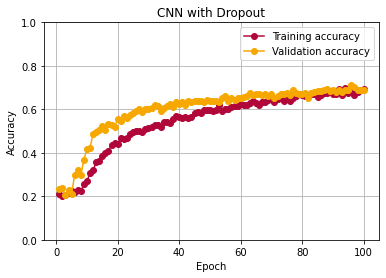

In [21]:
plot_history('CNN with Dropout', history_dropout, 0)